# Bayesian methods for machine learning - Week 2

## Recap: Jensen inequality

### Concave functions

A concave function is a function $f$ if, for any two points $a$, $b$: the value of the function at any point in $[a, b]$ is bigger or equal than all values in the segment between them.

Formally:

$f$ concave if:

$$
f(\alpha a + (1 - \alpha)b) \ge \alpha f(a) + (1 - \alpha) f(b) \\
0 < \alpha < 1 \\
\forall a, b, \alpha
$$

Visually:

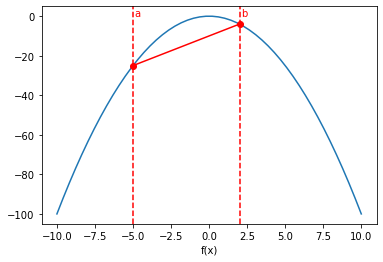

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def f(x): return -x**2

xs = np.linspace(-10, 10)
ys = [f(x) for x in xs]
plt.plot(xs, ys)

a, b = -5, 2

plt.plot([a, b], [f(a), f(b)], linestyle='-', color='red', marker='o')

plt.axvline(a, color='red', linestyle='--')
plt.text(a + 0.10, 0, 'a', color='red')

plt.axvline(b, color='red', linestyle='--')
plt.text(b + 0.10, 0, 'b', color='red')

plt.xlabel('x')
plt.xlabel('f(x)');

We can easily observe that for all $x$ between $a$ and $b$, the value on the function (i.e. blue line) is always higher or equal than the value in the segment between them (i.e. red line).

It can be generalized to any set of points using mixtures of values of $f$.

$f$ concave if:

$$
f(\alpha_1 a_1 + \alpha_2 a_2 + alpha_3 a_3) \ge \alpha_1 f(a_1) + \alpha_2 f(a_2) + \alpha_3 f(a_3) \\
\alpha_1 + \alpha_2 + \alpha_3 = 1 \\
\alpha_i \ge 0
$$

If we consider a discrete random variable $X$ with possible values $a_1, \ldots, a_N$ such that $P(X=a_i) = \alpha_i$. Then, we can rewrite:

$$
f\left(\mathbb{E}_{P\left(X\right)} X \right) \ge \mathbb{E}_{P\left(X\right)} f\left(X\right)
$$

Note that $f(x)$ is concave if and only if $-f(x)$ is convex.

## Recap: Kullback-Leibler divergence

It is a measure to quantify the distance between two probability distributions. Given two probability distributions $p$, $q$ their Kullbacl-Liebler divergence is notated as $\mathcal{KL}(q || p)$, which is defined as:

$$
\mathcal{KL}(q || p) = \int q(\pmb{x}) \log \frac{q(\pmb{x})}{p(\pmb{x})} d\pmb{x} = \mathbb{E}_{q(\pmb{x})} \log \frac{q}{p}
$$

Note that the integral is the expected value of the multiplication between $q(\pmb{x})$ and $\log \frac{q(\pmb{x})}{p(\pmb{x})} = \log q(\pmb{x}) - \log p(\pmb{x})$, which is a measure of distance between the distributions. Therefore KL divergence can be regarded as a weighted average of the difference between the two distributions.

**Properties**

- It is not symmetric: so KL-divergence cannot be considered as a strict mathematical distance function.

$$\mathcal{KL}(q || p) \neq \mathcal{KL}(p || q)$$

- The KL divergence of a distribution and itself is zero:

$$
\mathcal{KL}(q || q) = \int q(x) \log \frac{q(\pmb{x})}{q(\pmb{x})} d\pmb{x} = \int q(\pmb{x}) \log 1 d\pmb{x} = \int q(\pmb{x}) \cdot 0 \ d\pmb{x} = 0
$$

- It is non-negative:

$$
\mathcal{KL}(q || q) \ge 0
$$

This can be easily proved. As $p$, $q$ are probability distributions, they are inherently non-negative. If we use the negative of KL, we get:

$$
\begin{align*}
- \mathcal{KL}(q || p) &= - \int q(\pmb{x}) \log \frac{q(\pmb{x})}{p(\pmb{x})} d\pmb{x} \\
                     &= - \mathbb{E}_q \left( - \log \frac{q}{p} \right) \\
                     &= \mathbb{E}_q \left( - \log \frac{q}{p} \right) \\
                     &= \mathbb{E}_q \left( \log \frac{p}{q} \right)
\end{align*}
$$

As logarithm is a concave function, by definition, we can write (using Jensen Inequality):

$$
\begin{align*}
\log \left(\mathbb{E}_{q} \frac{p}{q} \right) & \ge \mathbb{E}_{q} \log \left(\frac{p}{q}\right) \\
\log \int q(\pmb{x}) \frac{p(\pmb{x})}{q(\pmb{x})} d\pmb{x} & \ge \mathbb{E}_{q} \log \left(\frac{p}{q}\right) \\
\log \int p(\pmb{x}) d\pmb{x} & \ge \mathbb{E}_{q} \log \left(\frac{p}{q}\right) \\
\log 1 & \ge \mathbb{E}_{q} \log \left(\frac{p}{q}\right) \\
0 & \ge \mathbb{E}_{q} \log \left(\frac{p}{q}\right) \\
\end{align*}
$$

If we go back to rewrite the negative of the negative of the KL divergence as:

$$
\begin{align*}
- \mathcal{KL}(q || p) & = \mathbb{E}_q \left( \log \frac{p}{q} \right) \\
- \mathcal{KL}(q || p) & \le 0 \implies \mathcal{KL}(p || q) \ge 0
\end{align*}
$$

## Expectation-maximization

### Generic form

Assuming we have a probabilistic model with observed variables $\pmb{X}$ and latent variables ${Z}$. We can express it graphically as:

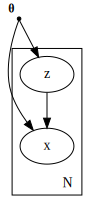

In [1]:
from graphviz import Digraph

plate_nb = Digraph()

plate_nb.node('T', xlabel='<<b><font point-size="12">&theta;</font></b>>', shape='point')

with plate_nb.subgraph(name='cluster') as plate:
    plate.node('x')
    plate.node('z')
    plate.attr(label='N', labeljust='r', labelloc='b')
    plate.edge('z', 'x')

plate_nb.edge('T', 'x')
plate_nb.edge('T', 'z')
    
plate_nb

Whose joint probability distribution can be defined as:
    
$$
P(\pmb{X}, \pmb{Z} | \pmb{\theta}) = P(\pmb{X} | \pmb{Z}, \pmb{\theta}) P(\pmb{Z} | \pmb{\theta})
$$

The EM algorithm tries to find the parameters that maximize the likelihood of the data. Given data $\pmb{X} = \{x_1, x_2, \ldots, x_N \}$, it can be obtained through marginalization:

$$
P(\pmb{X} | \pmb{\theta}) = \int P(\pmb{X} | \pmb{Z} = \pmb{z} = \pmb{a}, \pmb{\theta}) P(\pmb{Z} = \pmb{z} | \pmb{\theta}) d\pmb{z}
$$

which becomes, for discrete latent variables:

$$
P(\pmb{X} | \pmb{\theta}) = \sum_z P(\pmb{X} | \pmb{Z} = z, \pmb{\theta}) P(\pmb{Z} = \pmb{z} | \pmb{\theta})
$$

Then, we can maximize the (log) marginal likelihood as (let's assume latent variable belong to the continous domain):

$$
\begin{align*}
\theta^{*} & = \underset{\pmb{\theta}}{\mathrm{argmax}} \log P(\pmb{X} | \pmb{\theta}) \\
           & = \log \int P(\pmb{X} | \pmb{Z} = \pmb{z}, \pmb{\theta}) P(\pmb{Z} = \pmb{z} | \pmb{\theta}) d\pmb{z} \\
           & = \log \int P(\pmb{X}, \pmb{Z} = \pmb{z} | \pmb{\theta}) d\pmb{z}
\end{align*}
$$

Solving that is NP-hard; therefore, there is no guarantee to find the global maximum. However, we may find easier ways to proceed. We can use **Jensen inequality** to define a lower bound funcition $\mathcal{L}(\pmb{\theta})$ which is easier to maximize. Then, instead of maximizing the original log likelihood, we will maximize the lower bound function, so that:

$$
\log P(\pmb{X} | \pmb{\theta}) \ge \mathcal{L}(\pmb{\theta})
$$

Note that there inifinitely possible lower bound functions and that the quality of our solution relies on that choice. A family of functions $q$ is defined and the best function is chosen at each iteration of the algorithm. In the following example we see how three lower bound functions are defined and the third one, which is the maximum one and the one closer to the log likelihood function, is the preferred one.

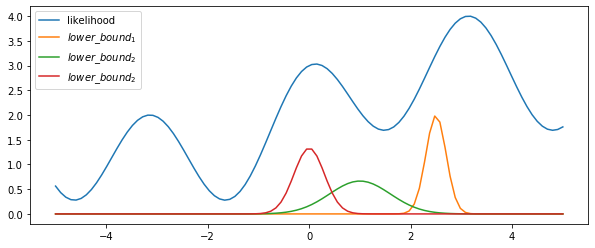

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

f = lambda x: np.sin(x/2) + np.cos(2*x) + 2
lb1 = lambda x: scipy.stats.norm(loc=2.5, scale=0.2).pdf(x)
lb2 = lambda x: scipy.stats.norm(loc=1.0, scale=0.60).pdf(x)
lb3 = lambda x: scipy.stats.norm(loc=0, scale=0.30).pdf(x)

fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

xs = np.linspace(-5, 5, 100)
ys = [f(x) for x in xs]

plt.plot(xs, ys, label='likelihood')
ax.plot(xs, lb1(xs), label=r'$lower\_bound_1$')
ax.plot(xs, lb2(xs), label=r'$lower\_bound_2$')
ax.plot(xs, lb3(xs), label=r'$lower\_bound_2$')
ax.legend()

Let's rewrite the log likelihood:

$$
\begin{align*}
\log P(\pmb{X} | \pmb{\theta}) & = \log \int P(\pmb{X}, \pmb{Z} = \pmb{z} | \pmb{\theta}) d\pmb{z} \\
                        & = \log \int \frac{q(\pmb{Z} = \pmb{z})}{q(\pmb{Z} = \pmb{z})} P(\pmb{X}, \pmb{Z} = \pmb{z} | \pmb{\theta}) d\pmb{z} \\
                        & = \log \left( \mathbb{E}_q \left[\frac{P(\pmb{X}, \pmb{Z} | \pmb{\theta})}{q(\pmb{Z})} \right] \right)
\end{align*}
$$

Note that we have added $\frac{q(\pmb{z_i} = \pmb{z})}{q(\pmb{z_i} = \pmb{z})}$ in the second step, as it makes no effect. As logarithm is a concave function, we can apply Jensen inequality to get the formula of the lower bound function $\mathcal{L}(\theta, q)$:

$$
\log P(\pmb{X} | \pmb{\theta}) = \log \left( \mathbb{E}_q \left[\frac{P(\pmb{X}, \pmb{Z} | \theta)}{q(\pmb{Z})} \right] \right) \ge \mathbb{E}_q \left[ \log \left( \frac{P(\pmb{X}, \pmb{Z} | \pmb{\theta})}{q(\pmb{Z})} \right) \right] = \mathcal{L(\pmb{\theta}, q)}, \forall q
$$

As maximizing the log marginal log likelihood is a complex task, instead, we are going to maximize the surrogate $\mathcal{L}(\pmb{\theta}, q)$, which is usually referred as the **variational lower bound** (i.e. variational as it relies on $q$).

In order to get the best parameters for the latent variable model, we alternative Expectation (i.e. E-step) and maximization (i.e. M-step) steps.

### E-Step

In the expectation step at iteration $k$, we select the best $q$ distribution that maximizes the lower bound, fixing the parameters $\theta^{k}$. That is equivalent to minimizing the gap between $\log P(\pmb{X} | \pmb{\theta}) - \mathcal{L}(\pmb{\theta}, q)$. So we want to compute:

$$
\begin{align*}
q^{k+1} & = \underset{q}{\mathrm{argmax}} \ \mathcal{L}(\pmb{\theta}^{k}, q) \\
        & = \underset{q}{\mathrm{argmin}} \log P(\pmb{X} | \pmb{\theta^{k}}) - \mathcal{L}(\pmb{\theta^{k}}, q)
\end{align*}
$$

Let's rewrite the gap above:

$$
\begin{align*}
\log P(\pmb{X} | \pmb{\theta}) - \mathcal{L}(\pmb{\theta}, q) & =  \log P(\pmb{X} | \pmb{\theta}) - \int q(\pmb{Z} = \pmb{z}) \log \frac{P(\pmb{X}, \pmb{Z = \pmb{z}} | \pmb{\theta})}{q(\pmb{Z} = \pmb{z})} d\pmb{z} \\
                                                  & = \log P(\pmb{X} | \pmb{\theta}) \int q(\pmb{Z} = \pmb{z}) d\pmb{z} - \int q(\pmb{Z} = \pmb{z}) \log \frac{P(\pmb{X}, \pmb{Z = \pmb{z}} | \pmb{\theta})}{q(\pmb{Z} = \pmb{z})} d\pmb{z} \\
                                                  & = \int \log P(\pmb{X} | \pmb{\theta}) q(\pmb{Z} = \pmb{z}) - q(\pmb{Z} = \pmb{z}) \log \frac{P(\pmb{X}, \pmb{Z = \pmb{z}} | \pmb{\theta})}{q(\pmb{Z} = \pmb{z})} d\pmb{z} \\
                                                  & = \int q(\pmb{Z} = \pmb{z}) \left( \log P(\pmb{X} | \pmb{\theta}) - \log \frac{P(\pmb{X}, \pmb{Z = \pmb{z}} | \pmb{\theta})}{q(\pmb{Z} = \pmb{z})} \right) d\pmb{z} \\
                                                  & = \int q(\pmb{Z} = \pmb{z}) \left( \log \frac{P(\pmb{X} | \pmb{\theta})q(\pmb{Z} = \pmb{z})}{P(\pmb{X}, \pmb{Z = \pmb{z}} | \pmb{\theta})} \right) d\pmb{z} \\
                                                  & = \int q(\pmb{Z} = \pmb{z}) \left( \log \frac{P(\pmb{X} | \pmb{\theta})q(\pmb{Z} = \pmb{z})}{P(\pmb{Z} = \pmb{z} |\pmb{X}, \pmb{\theta})P(\pmb{X}|\pmb{\theta})} \right) d\pmb{z} \\
                                                  & = \int q(\pmb{Z} = \pmb{z}) \left( \log \frac{q(\pmb{Z} = \pmb{z})}{P(\pmb{Z} = \pmb{z} |\pmb{X}, \pmb{\theta})} \right) d\pmb{z} \\
                                                  & = \mathcal{KL} \left(q(\pmb{Z}) || P(\pmb{Z}|\pmb{X}, \pmb{\theta})\right)
\end{align*}
$$

Some considerations:

- In the second step, we introduce multiplier $\int q(\pmb{Z} = \pmb{z}) d\pmb{z}$, which equals to 1, so it makes no difference.
- In the sixth step, we make use of the product rule probability (i.e. $P(\pmb{X}, \pmb{Z}| \pmb{\theta}) = P(\pmb{Z}|\pmb{X}, \pmb{\theta})P(\pmb{X}|\pmb{\theta})$).

We see that the distance between the log likelihood function and the lower bound is equivalent to the sum of Kullback-Liebler divergences between the $q$ and the posterior of the hidden variables at parameters $\theta$. Therefore, we can express:

$$
\underset{q}{\mathrm{argmin}} \ \log P(\pmb{X} | \pmb{\theta}) - \mathcal{L}(\pmb{\theta}, q) = \underset{q}{\mathrm{argmin}} \ \mathcal{KL} \left(q(\pmb{Z}) || P(\pmb{Z}|\pmb{X}, \pmb{\theta})\right)
$$

Recall that, by definition:

- $\mathcal{KL}(q, p) \ge 0$
- $\mathcal{KL}(q, q) = 0$

Therefore, the value of the difference is non-negative and has its lowest value when both distributions are the same. In order to minimize the gap, we need to set the function $q$ to the posterior $P(\pmb{Z}|\pmb{X}, \pmb{\theta})$. By doing so, as the gap has been reduced 0, the value of the lower bound at $\pmb{\theta}$ will be equal to the log likelihood function at that point.

Summing up, the function $q$ at step $k+1$ that maximizes the lower bound at parameters $\pmb{\theta}^{k}$, is computed as:

$$
q^{k+1} (\pmb{Z}) = P(\pmb{Z}|\pmb{X}, \pmb{\theta}^{k})
$$

### M-Step

The objective of the maximization step at iteration $k+1$ is to maximize the lower bound $\mathcal{L}(q, \pmb{\theta})$ with respect to parameters $\pmb{\theta}$, given $q_{k+1}$ is fixed:

$$
\begin{align*}
\pmb{\theta}^{k+1} & = \underset{\pmb{\theta}}{\mathrm{argmax}} \ \mathcal{L}(q_{k+1}, \pmb{\theta}) \\
                   & = \underset{\pmb{\theta}}{\mathrm{argmax}} \ \int q_{k+1}(\pmb{Z} = \pmb{z}) \log \frac{P(\pmb{X}, \pmb{Z} = \pmb{z} | \pmb{\theta})}{q(\pmb{Z} = z)} d\pmb{z} \\
                   & = \underset{\pmb{\theta}}{\mathrm{argmax}} \ \int q_{k+1}(\pmb{Z} = \pmb{z}) \left[ \log P(\pmb{X}, \pmb{Z} = \pmb{z} | \pmb{\theta}) - \log q_{k+1}(\pmb{Z} = \pmb{z}) \right] d\pmb{z} \\
                   & = \underset{\pmb{\theta}}{\mathrm{argmax}} \ \int q_{k+1}(\pmb{Z} = \pmb{z}) \log P(\pmb{X}, \pmb{Z} = \pmb{z} | \pmb{\theta}) d\pmb{z} - \int q_{k+1}(\pmb{Z} = \pmb{z}) \log q_{k+1}(\pmb{Z} = \pmb{z}) d\pmb{z} \\
                   & = \underset{\pmb{\theta}}{\mathrm{argmax}} \ \int q_{k+1}(\pmb{Z} = \pmb{z}) \log P(\pmb{x_i}, \pmb{Z} = \pmb{z} | \pmb{\theta}) d\pmb{z} \\
                   & = \underset{\pmb{\theta}}{\mathrm{argmax}} \int P(\pmb{Z} = \pmb{z} | \pmb{X}, \pmb{\theta}^{k}) \log P(\pmb{X}, \pmb{Z} = \pmb{z} | \pmb{\theta}) d\pmb{z} \\
                   & = \underset{\pmb{\theta}}{\mathrm{argmax}} \ \mathbb{E}_{q_{k+1}} \log P(\pmb{X}, \pmb{Z} = \pmb{z} | \pmb{\theta}) d\pmb{z} \\
\end{align*} 
$$

Note that:

- We can omit the second term in the fourth step (i.e. negative entropy), as it does not depend on the parameters.
- We know that the $q^{k+1}$ distribution equals to the posterior of the hidden variables for parameters $\pmb{\theta}^{k}$.

To sum up, the M-step consists on computing:

$$
\pmb{\theta}^{k+1} = \underset{\pmb{\theta}}{\mathrm{argmax}} \int P(\pmb{Z} | \pmb{X}, \pmb{\theta}^{k}) \log P(\pmb{X}, \pmb{Z} | \pmb{\theta}) d\pmb{Z}
$$

Which is also common referred expressed as:

$$
\begin{align*}
\pmb{\theta}^{k+1} & = \underset{\pmb{\theta}}{\mathrm{argmax}} \ \mathbb{E}_{q^{k+1}} \log P(\pmb{X}, \pmb{Z} | \pmb{\theta}) \\
\pmb{\theta}^{k+1} & = \underset{\pmb{\theta}}{\mathrm{argmax}} \ \mathcal{Q}(\pmb{\theta}, \pmb{\theta}^{k})
\end{align*}
$$

After maximizing the lower bound, we get a new estimator $\pmb{\theta}^{k+1}$. The value of the log likelihood at this new point increases (if not already a local maximum) and, per definition, is at least equal to the lower bound value at that point. The KL divergence at this new point is, consequently, non-zero.

Assumptions can be made (e.g. use mixtures from exponential families) so the resulting function to optimize in this step is convex. When the M step is intractable, *Generalized EM* are used (out of scope).

### Properties

- EM algorithms is guaranteed to converge at a local maximum or saddle point. If the algorithm converges to a local maximum of the lower bound $\mathcal{L}(q, \pmb{\theta})$, it will also correspond to a local maximum of the log likelihood $\log P(\pmb{X}|\pmb{\theta})$ function. 

- Each EM cycle is ensured to increase the log likelihood function. By definition of the lower bound function, at the end of iteration $k$, the log likelihood is at least the value of the lower bound:

$$
\log P(\pmb{X} | \pmb{\theta}^{k+1}) \ge \mathcal{L}(\pmb{\theta}^{k+1}, q^{k+1})
$$

We also know that, after the M-step during iteration $k$, the value of the lower bound at the next parameters estimation is at least as big as the previous one:

$$
\mathcal{L}(\pmb{\theta}^{k+1}, q^{k+1}) \ge \mathcal{L}(\pmb{\theta}^{k}, q^{k+1})
$$

And we know that after the E-step at iteration $k$, the gap between the log likelihood and the lower bound is 0:

$$
\mathcal{L}(\pmb{\theta}^{k}, q^{k+1}) = \log P(\pmb{X} | \pmb{\theta}^{k})
$$

Therefore:

$$
\log P(\pmb{X} | \pmb{\theta}^{k+1}) \ge \log P(\pmb{X} | \pmb{\theta}^{k})
$$

- In some distribution families (e.g. exponential) updates of the parameters can be performed online, one per each of the input instances. It may help converge faster, as each of the incremental steps increases the value of the lok likelihood function.